In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, Dense, Input, add, Activation, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Model
from keras import optimizers, regularizers
from keras.models import Sequential
from keras import backend as K
from keras.utils import to_categorical
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
from EC_Func.metric_plot import plot_confusion_matrix, metric_cal
warnings.filterwarnings("ignore")
import GPy
import GPyOpt

Using TensorFlow backend.


In [2]:
def I_Know_Percent(y_true, y_pred, raw_pred): # calculate % of I know
    trusted_index = np.where(y_pred < (np.max(y_true)+0.1))[0]
    M1 = len(trusted_index)/len(y_true)
    return M1

In [3]:
folder = '../Dataset/UCR_TimeSeries/SyntheticControl/'
file = os.listdir(folder)

In [4]:
def return_index(file_tar): # select training and testing file
    index = [None, None]
    for name in file_tar:
        if name.split('_')[-1] == 'TRAIN.tsv':
            index[0] = name
        elif name.split('_')[-1] == 'TEST.tsv':
            index[1] = name
    
    return index

0


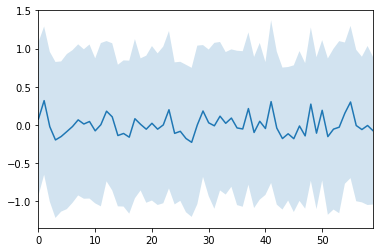

1


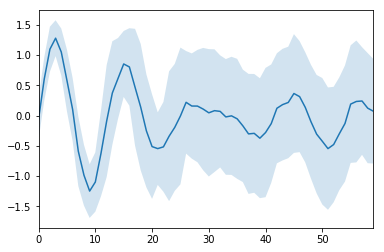

2


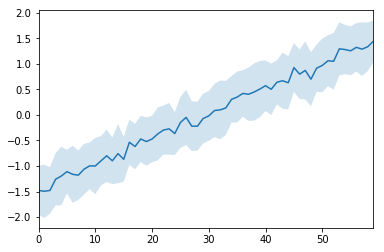

3


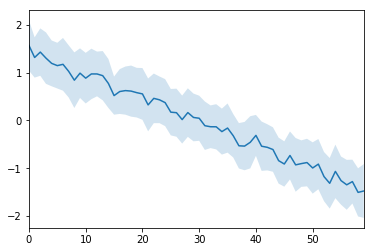

4


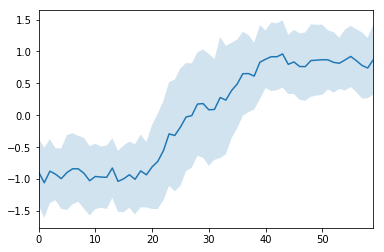

5


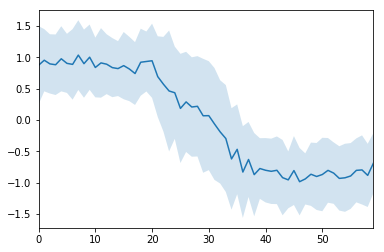

In [5]:
train_test = return_index(file)
train_data = pd.read_csv(folder+train_test[0], sep="\t", header=None)
test_data = pd.read_csv(folder+train_test[1], sep="\t", header=None)

train_y = train_data[0].values - np.min(train_data[0].values)
test_y = test_data[0].values - np.min(train_data[0].values)
train_x = train_data.iloc[:,1:].values
test_x = test_data.iloc[:,1:].values

for i in list(set(train_y)):
    print(i)
    index = np.where(train_y == i)[0]
    sns.tsplot(data=train_x[index, :], ci = 'sd')
    plt.show()


In [6]:
# split training data into training and validation
train_index = []
num_list = [40, 40, 40, 40, 40, 40] # select 240 for training and 60 TS for validation
for i in range(6):
    index = np.random.choice(np.where(train_y == i)[0], size = num_list[i], replace=False)
    train_index.append(index)
    
train_index = np.concatenate(train_index)
validation_index = np.setdiff1d(list(range(len(train_y))), train_index)

In [7]:
train_label = train_y[train_index]
validation_label = train_y[validation_index]
test_label = test_y
train_data = train_x[train_index]
validation_data = train_x[validation_index]
test_data = test_x

In [8]:
# standardize
mean = np.mean(train_data)
std = np.std(train_data)

train_data = (train_data - mean)/std
validation_data = (validation_data - mean)/std
test_data = (test_data - mean)/std

skip_interval = 1
window_size = 55
TS_length = train_x.shape[1]

In [9]:
# convert to window
train_combined = []
validation_combined = []
test_combined = []
train_label_c = []
validation_label_c = []
test_label_c= []
for i in range(0, TS_length, skip_interval):
    if i + window_size <= TS_length:
        train_combined.append(train_data[:, i:i+window_size])
        train_label_c.append(train_label)
        
        validation_combined.append(validation_data[:, i:i+window_size])
        validation_label_c.append(validation_label)
        
        test_combined.append(test_data[:, i:i+window_size])
        test_label_c.append(test_label)
        
train_data = np.concatenate(train_combined, axis = 0)
validation_data = np.concatenate(validation_combined, axis = 0)
test_data = np.concatenate(test_combined, axis = 0)

train_label = np.concatenate(train_label_c)
validation_label = np.concatenate(validation_label_c)
test_label = np.concatenate(test_label_c)

In [10]:
# preprocess for CNN
X_train = np.expand_dims(np.expand_dims(train_data, axis=2), axis = 1)
X_validation = np.expand_dims(np.expand_dims(validation_data, axis=2), axis = 1)
X_test = np.expand_dims(np.expand_dims(test_data, axis=2), axis = 1)

y_train_int = train_label
y_validation_int = validation_label
y_test_int = test_label

y_train = to_categorical(train_label, len(list(set(train_y))))
y_validation = to_categorical(validation_label, len(list(set(train_y))))
y_test = to_categorical(test_label, len(list(set(test_y))))

In [11]:
X_train.shape

(1440, 1, 55, 1)

In [12]:
X_validation.shape

(360, 1, 55, 1)

In [13]:
X_test.shape

(1800, 1, 55, 1)

# Build base model

In [14]:
def build_model(input_shape = 1, window_size = 301):
    model = Sequential()
    model.add(Conv2D(9, (input_shape, 12), padding='valid', activation='relu', kernel_initializer='he_normal',
                     input_shape=(input_shape, window_size, 1)))
    
    model.add(Conv2D(12, (input_shape, 16), padding='valid', activation='relu', kernel_initializer='he_normal'))

    model.add(Conv2D(9, (input_shape, 12), padding='valid', activation='relu', kernel_initializer='he_normal'))
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(6, activation = None, kernel_initializer='he_normal'))
    
    model.add(Activation('softmax'))
    
    sgd = optimizers.Adam(lr=0.0005)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

model = build_model(window_size = window_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 44, 9)          117       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 29, 12)         1740      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 18, 9)          1305      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 60        
_________________________________________________________________
activation_1 (Activation)    (None, 6)                 0         
Total params: 3,222
Trainable params: 3,222
Non-trainable params: 0
_________________________________________________________________


In [15]:
n_samples = X_train.shape[0]
batch_size = 128
n_epochs = 32

print('--------------- fit model -----------------')
model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=n_epochs,
              validation_data=(X_validation, y_validation),
              shuffle=True, verbose = 1)

pred = model.predict_classes(X_test)
print(confusion_matrix(np.argmax(y_test, axis = 1), pred))
print(accuracy_score(np.argmax(y_test, axis = 1), pred))

--------------- fit model -----------------
Train on 1440 samples, validate on 360 samples
Epoch 1/32
1440/1440 [==============================] - 0s 292us/step - loss: 1.9904 - acc: 0.2215 - val_loss: 1.8188 - val_acc: 0.2833
Epoch 2/32
1440/1440 [==============================] - 0s 80us/step - loss: 1.7410 - acc: 0.2785 - val_loss: 1.6756 - val_acc: 0.3028
Epoch 3/32
1440/1440 [==============================] - 0s 69us/step - loss: 1.6418 - acc: 0.3042 - val_loss: 1.5978 - val_acc: 0.3861
Epoch 4/32
1440/1440 [==============================] - 0s 63us/step - loss: 1.5723 - acc: 0.3889 - val_loss: 1.5208 - val_acc: 0.4667
Epoch 5/32
1440/1440 [==============================] - 0s 63us/step - loss: 1.4892 - acc: 0.4986 - val_loss: 1.4162 - val_acc: 0.5639
Epoch 6/32
1440/1440 [==============================] - 0s 73us/step - loss: 1.3766 - acc: 0.5458 - val_loss: 1.2921 - val_acc: 0.5639
Epoch 7/32
1440/1440 [==============================] - 0s 75us/step - loss: 1.2602 - acc: 0.5833 

# Epistemic Classifier

In [16]:
from EC_Func.EC_Classifier_Ball_Tree import EpistemicClassifier
layer_interest = [2, 3]
EC = EpistemicClassifier(model, layer_interest, metric = 'minkowski', p = 2)
EC.fit(X_train, y_train_int)

Using metric: minkowski
caching hiddens
layer selected: 
conv2d_3
global_average_pooling2d_1
using Ball Tree for NN Search
building tree for layer 0
building tree for layer 1


number of neighbor for each layer:  [1, 1]
M1:  0.9772222222222222
M2:  0.9954519613411055
M3:  0.8666666666377778
M4:  0.016666666666666666
M5:  0.006111111111111111
M6:  0.3666666666544444


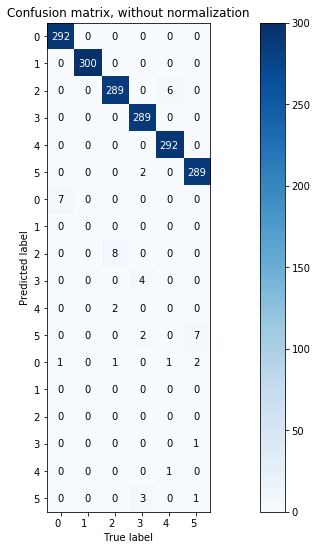

 --------------------------------- 
number of neighbor for each layer:  [2, 2]
M1:  0.9722222222222222
M2:  0.9954285714280027
M3:  0.860465116259059
M4:  0.02388888888888889
M5:  0.0038888888888888888
M6:  0.16279069767063278


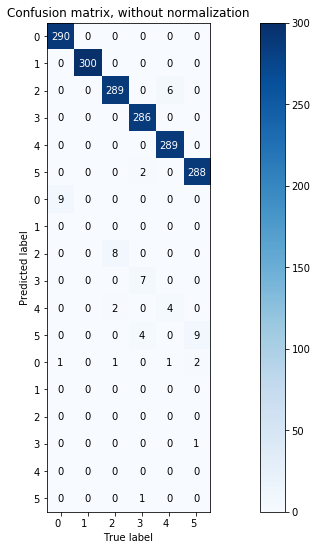

 --------------------------------- 
number of neighbor for each layer:  [3, 3]
M1:  0.9677777777777777
M2:  0.9959816303094168
M3:  0.8148148147997257
M4:  0.03
M5:  0.0022222222222222222
M6:  0.07407407407270233


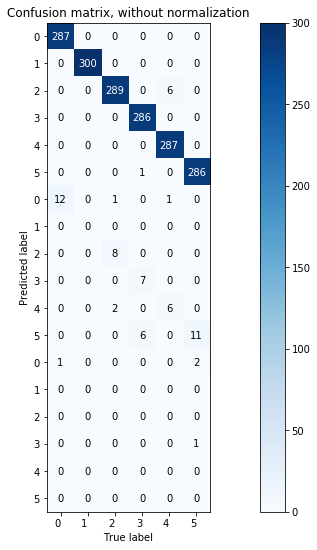

 --------------------------------- 
number of neighbor for each layer:  [4, 4]
M1:  0.9588888888888889
M2:  0.9959443800689479
M3:  0.8571428571306122
M4:  0.03888888888888889
M5:  0.0022222222222222222
M6:  0.057142857142040815


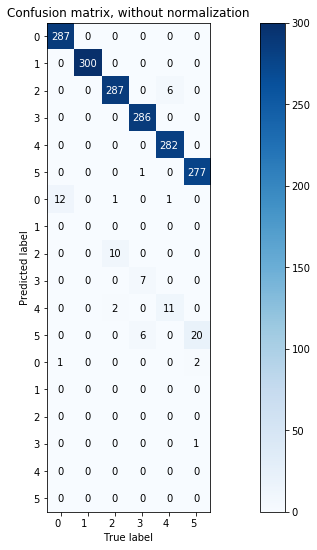

 --------------------------------- 
number of neighbor for each layer:  [5, 5]
M1:  0.955
M2:  0.9965095986032597
M3:  0.8481012658120494
M4:  0.04388888888888889
M5:  0.0011111111111111111
M6:  0.02531645569588207


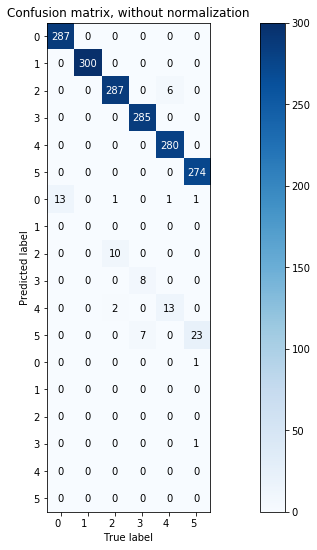

 --------------------------------- 
number of neighbor for each layer:  [6, 6]
M1:  0.9505555555555556
M2:  0.9964932787837543
M3:  0.8620689655073325
M4:  0.04833333333333333
M5:  0.0011111111111111111
M6:  0.0229885057468622


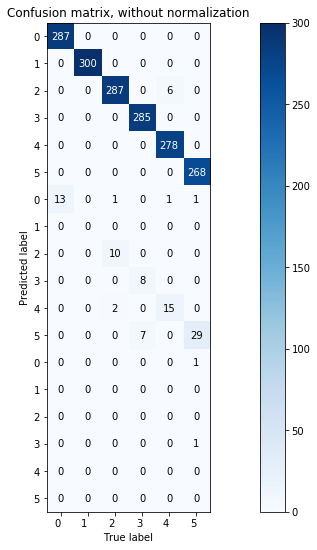

 --------------------------------- 
number of neighbor for each layer:  [7, 7]
M1:  0.9466666666666667
M2:  0.9964788732388519
M3:  0.8723404255226347
M4:  0.052222222222222225
M5:  0.0011111111111111111
M6:  0.021276595744454504


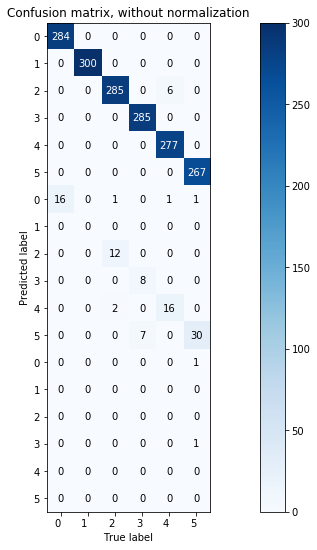

 --------------------------------- 
number of neighbor for each layer:  [8, 8]
M1:  0.9377777777777778
M2:  0.9964454976297414
M3:  0.8909090909009917
M4:  0.06111111111111111
M5:  0.0011111111111111111
M6:  0.018181818181652893


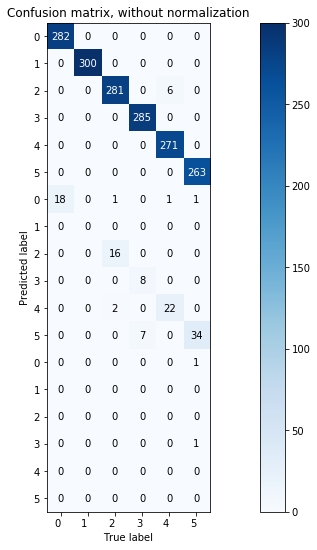

 --------------------------------- 
number of neighbor for each layer:  [9, 9]
M1:  0.9338888888888889
M2:  0.9964306960136845
M3:  0.897435897428227
M4:  0.065
M5:  0.0011111111111111111
M6:  0.01709401709387099


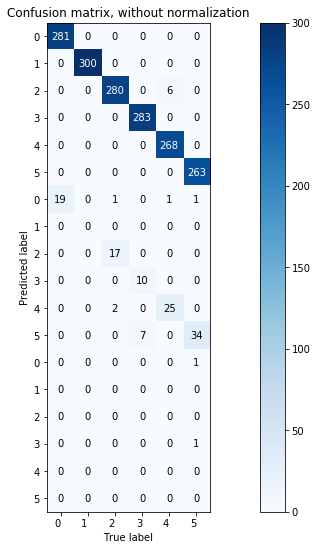

 --------------------------------- 
number of neighbor for each layer:  [10, 10]
M1:  0.9255555555555556
M2:  0.9963985594231715
M3:  0.9090909090840221
M4:  0.07333333333333333
M5:  0.0011111111111111111
M6:  0.015151515151400369


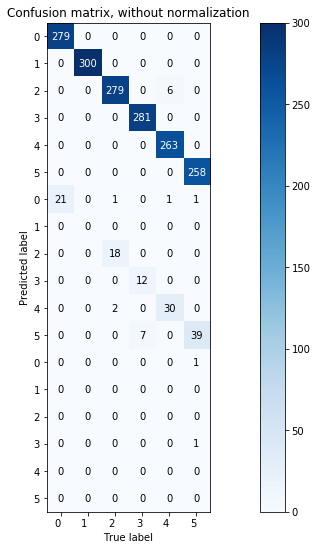

 --------------------------------- 
number of neighbor for each layer:  [11, 11]
M1:  0.9194444444444444
M2:  0.9963746223558935
M3:  0.9160839160775099
M4:  0.07944444444444444
M5:  0.0011111111111111111
M6:  0.013986013985916182


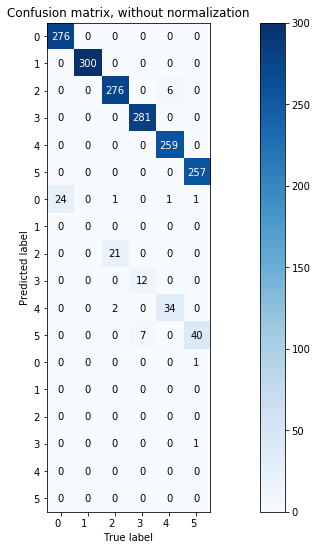

 --------------------------------- 
number of neighbor for each layer:  [12, 12]
M1:  0.9138888888888889
M2:  0.9963525835860204
M3:  0.9215686274449572
M4:  0.085
M5:  0.0011111111111111111
M6:  0.013071895424751165


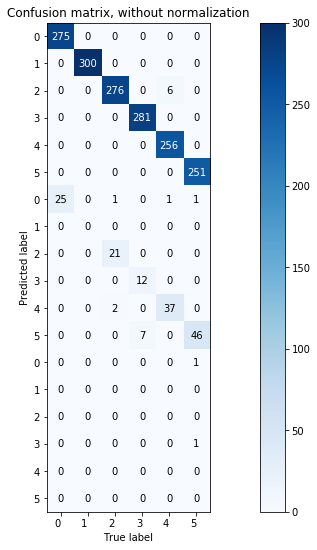

 --------------------------------- 
number of neighbor for each layer:  [13, 13]
M1:  0.9055555555555556
M2:  0.9963190184042967
M3:  0.9285714285659015
M4:  0.09333333333333334
M5:  0.0011111111111111111
M6:  0.011904761904691044


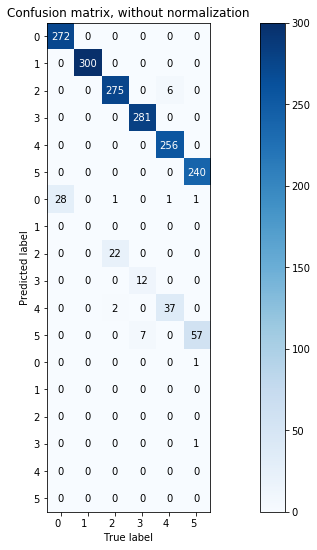

 --------------------------------- 
number of neighbor for each layer:  [14, 14]
M1:  0.9016666666666666
M2:  0.9963031423284064
M3:  0.9314285714232491
M4:  0.09722222222222222
M5:  0.0011111111111111111
M6:  0.011428571428506123


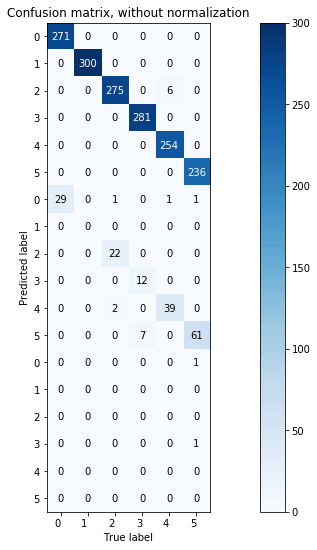

 --------------------------------- 
number of neighbor for each layer:  [15, 15]
M1:  0.8961111111111111
M2:  0.9962802231859912
M3:  0.9351351351300804
M4:  0.10277777777777777
M5:  0.0011111111111111111
M6:  0.010810810810752374


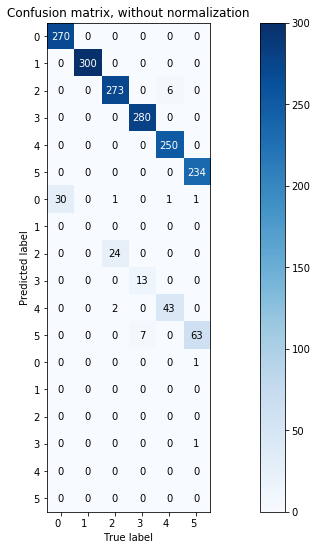

 --------------------------------- 
number of neighbor for each layer:  [16, 16]
M1:  0.8905555555555555
M2:  0.9962570180904577
M3:  0.9384615384567259
M4:  0.10833333333333334
M5:  0.0011111111111111111
M6:  0.01025641025635766


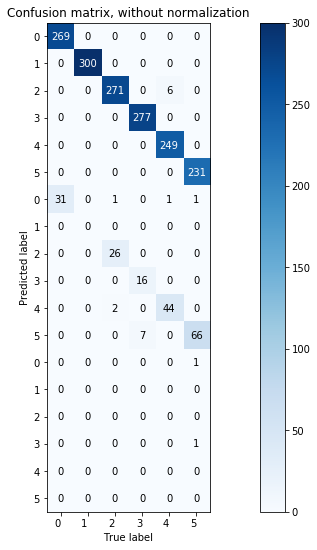

 --------------------------------- 
number of neighbor for each layer:  [17, 17]
M1:  0.8872222222222222
M2:  0.9962429555410167
M3:  0.9402985074580085
M4:  0.11166666666666666
M5:  0.0011111111111111111
M6:  0.009950248756169401


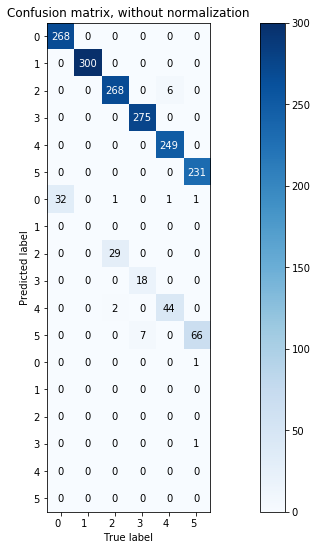

 --------------------------------- 
number of neighbor for each layer:  [18, 18]
M1:  0.8822222222222222
M2:  0.9974811083117144
M3:  0.9333333333288889
M4:  0.11666666666666667
M5:  0.0011111111111111111
M6:  0.009523809523764172


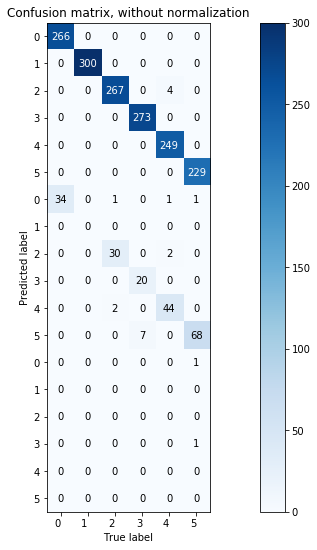

 --------------------------------- 
number of neighbor for each layer:  [19, 19]
M1:  0.8777777777777778
M2:  0.9974683544297485
M3:  0.9315068493108151
M4:  0.12166666666666667
M5:  0.0005555555555555556
M6:  0.0045662100456412506


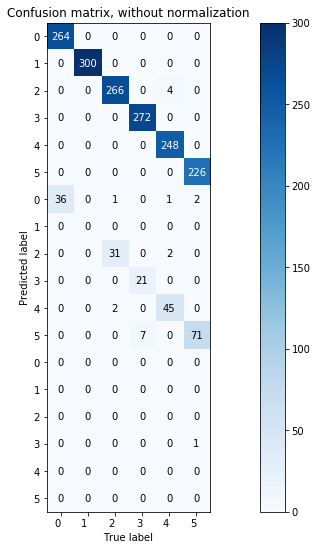

 --------------------------------- 
number of neighbor for each layer:  [20, 20]
M1:  0.8738888888888889
M2:  0.9974570883655451
M3:  0.9295154184981079
M4:  0.12611111111111112
M5:  0.0


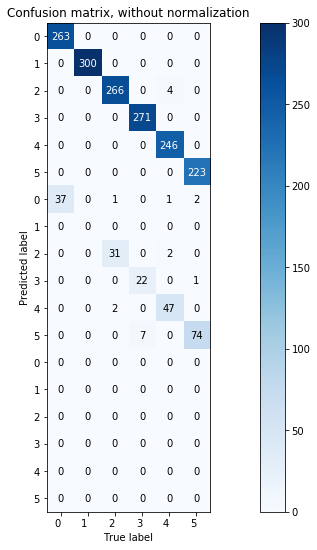

 --------------------------------- 
number of neighbor for each layer:  [21, 21]
M1:  0.87
M2:  0.9974457215830157
M3:  0.9316239316199504
M4:  0.13
M5:  0.0


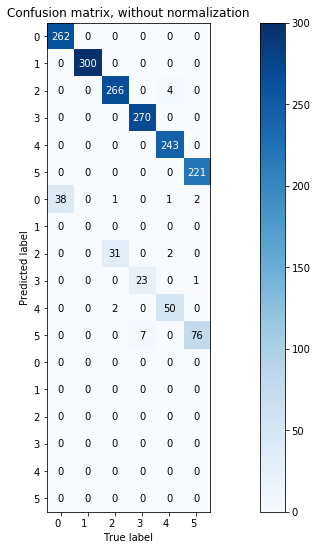

 --------------------------------- 
number of neighbor for each layer:  [22, 22]
M1:  0.8661111111111112
M2:  0.9974342527254667
M3:  0.9336099585023502
M4:  0.1338888888888889
M5:  0.0


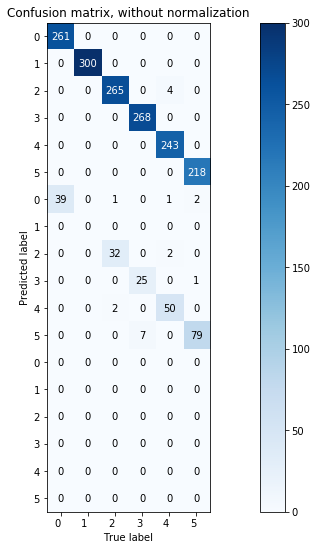

 --------------------------------- 
number of neighbor for each layer:  [23, 23]
M1:  0.8605555555555555
M2:  0.9974176888308602
M3:  0.9362549800759512
M4:  0.13944444444444445
M5:  0.0


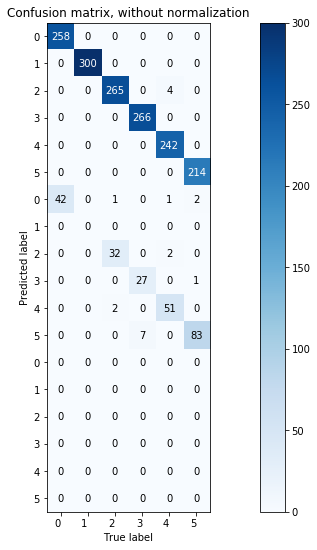

 --------------------------------- 
number of neighbor for each layer:  [24, 24]
M1:  0.855
M2:  0.9974009096809634
M3:  0.9386973180040663
M4:  0.145
M5:  0.0


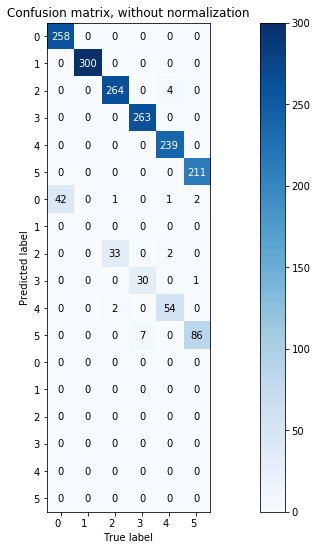

 --------------------------------- 


In [17]:
for i in range(1, 25):
    print('number of neighbor for each layer: ',[1*i, 1*i])
    pred = EC.predict_class(X_test, n_neigh = [1*i, 1*i])
    plot_confusion_matrix(y_test_int, pred,  model.predict_classes(X_test))
    print(' --------------------------------- ')

30
Epsilon for each layer: [8.0, 1.0]
M1:  0.21888888888888888
M2:  0.9999999999974619
M3:  0.0
M4:  0.0
M5:  0.7811111111111111


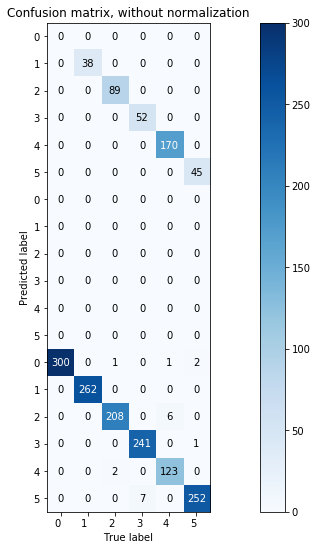

----------------------
31
Epsilon for each layer: [8.574187700290345, 1.0717734625362931]
M1:  0.27444444444444444
M2:  0.9999999999979757
M3:  0.0
M4:  0.0
M5:  0.7255555555555555


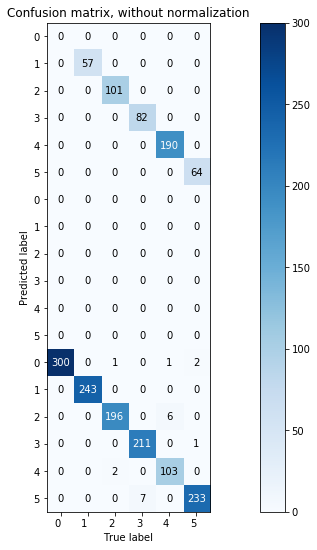

----------------------
32
Epsilon for each layer: [9.18958683997628, 1.148698354997035]
M1:  0.33555555555555555
M2:  0.9999999999983444
M3:  0.0
M4:  0.0
M5:  0.6644444444444444


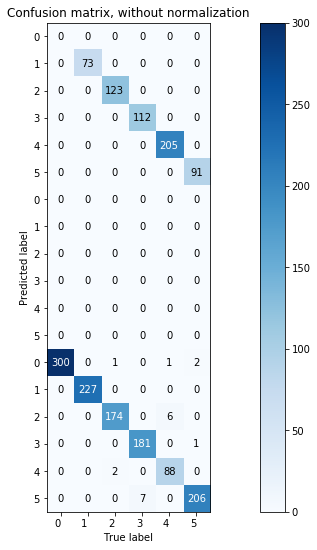

----------------------
33
Epsilon for each layer: [9.849155306759329, 1.231144413344916]
M1:  0.42777777777777776
M2:  0.9999999999987013
M3:  0.99999999975
M4:  0.0022222222222222222
M5:  0.57
M6:  256.499999935875


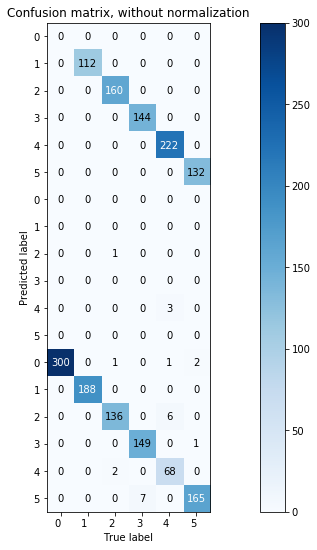

----------------------
34
Epsilon for each layer: [10.556063286183154, 1.3195079107728942]
M1:  0.49944444444444447
M2:  0.9999999999988877
M3:  0.9999999999166667
M4:  0.006666666666666667
M5:  0.4938888888888889
M6:  74.08333332715972


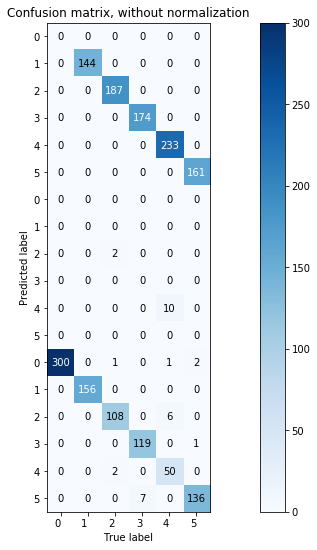

----------------------
35
Epsilon for each layer: [11.313708498984761, 1.4142135623730951]
M1:  0.5538888888888889
M2:  0.999999999998997
M3:  0.99999999996
M4:  0.013888888888888888
M5:  0.43222222222222223
M6:  31.1199999987552


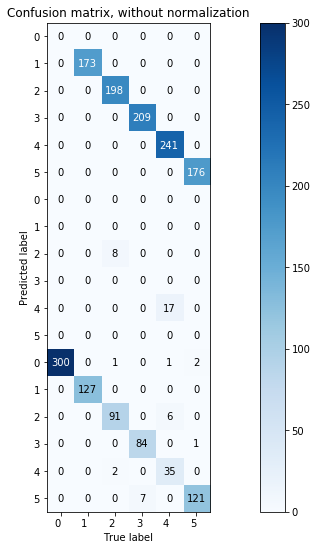

----------------------
36
Epsilon for each layer: [12.125732532083186, 1.5157165665103982]
M1:  0.5927777777777777
M2:  0.9999999999990627
M3:  0.9999999999750001
M4:  0.022222222222222223
M5:  0.385
M6:  17.324999999566877


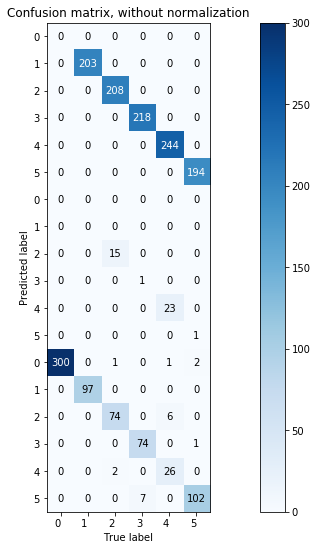

----------------------
37
Epsilon for each layer: [12.99603834169977, 1.6245047927124712]
M1:  0.6283333333333333
M2:  0.9999999999991158
M3:  0.9374999999853515
M4:  0.035555555555555556
M5:  0.33611111111111114
M6:  9.453124999852294


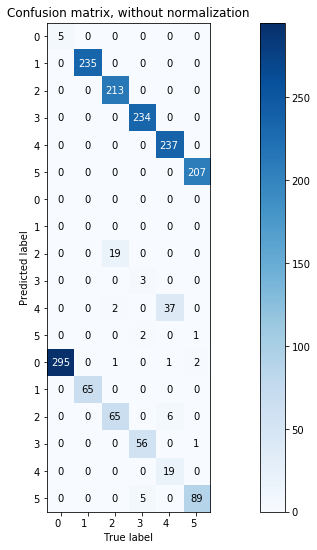

----------------------
38
Epsilon for each layer: [13.928809012737984, 1.741101126592248]
M1:  0.6627777777777778
M2:  0.9999999999991618
M3:  0.9537037036948731
M4:  0.06
M5:  0.2772222222222222
M6:  4.620370370327589


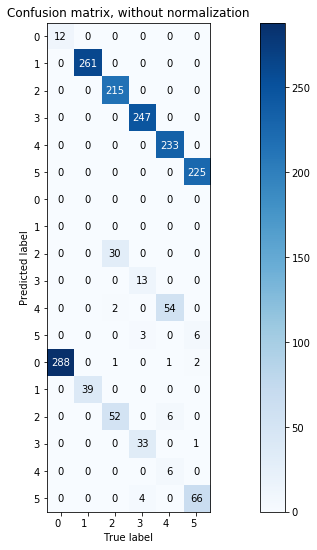

----------------------
39
Epsilon for each layer: [14.928527864588919, 1.8660659830736148]
M1:  0.6855555555555556
M2:  0.9967585089132928
M3:  0.948051948045792
M4:  0.08555555555555555
M5:  0.2288888888888889
M6:  2.6753246753073032


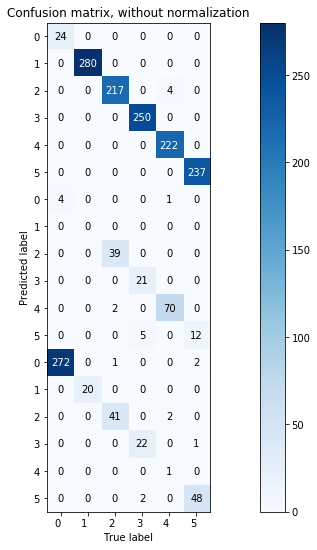

----------------------
40
Epsilon for each layer: [16.0, 2.0]
M1:  0.7027777777777777
M2:  0.9952569169952606
M3:  0.9465240641660614
M4:  0.10388888888888889
M5:  0.19333333333333333
M6:  1.8609625668349683


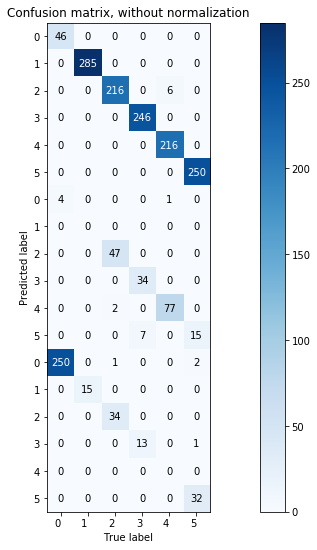

----------------------
41
Epsilon for each layer: [17.148375400580687, 2.143546925072586]
M1:  0.7205555555555555
M2:  0.9953739398604508
M3:  0.9568965517200134
M4:  0.1288888888888889
M5:  0.15055555555555555
M6:  1.1681034482708272


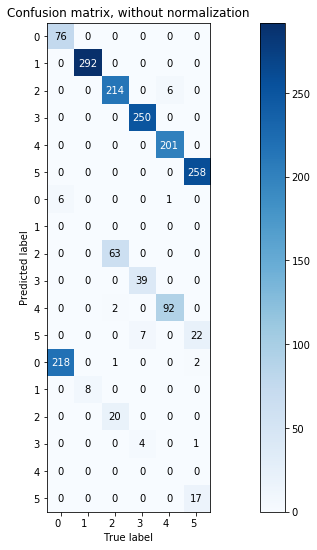

----------------------
42
Epsilon for each layer: [18.37917367995256, 2.29739670999407]
M1:  0.7288888888888889
M2:  0.9969512195114353
M3:  0.9590443685974095
M4:  0.16277777777777777
M5:  0.10833333333333334
M6:  0.6655290102366365


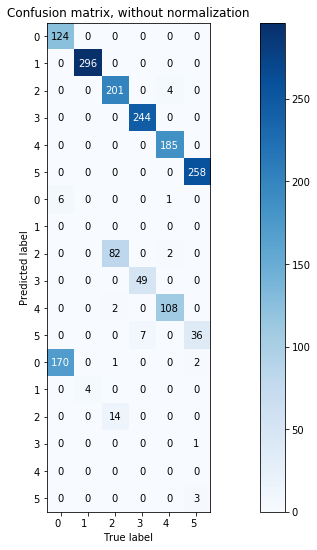

----------------------
43
Epsilon for each layer: [19.698310613518657, 2.462288826689832]
M1:  0.7255555555555555
M2:  0.9999999999992343
M3:  0.9537572254307695
M4:  0.1922222222222222
M5:  0.08222222222222222
M6:  0.42774566473864817


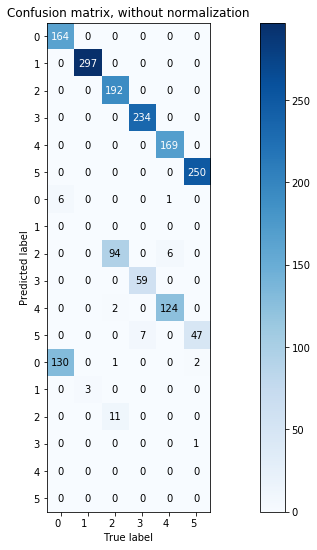

----------------------
44
Epsilon for each layer: [21.112126572366314, 2.6390158215457893]
M1:  0.7
M2:  0.9999999999992064
M3:  0.9621749408960706
M4:  0.235
M5:  0.065
M6:  0.27659574468019715


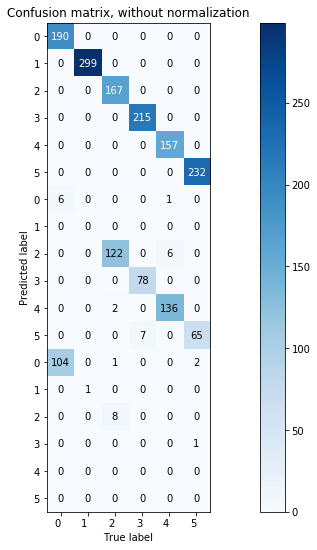

----------------------
45
Epsilon for each layer: [22.627416997969522, 2.8284271247461903]
M1:  0.6633333333333333
M2:  0.9999999999991624
M3:  0.9679849340848061
M4:  0.295
M5:  0.041666666666666664
M6:  0.14124293785284137


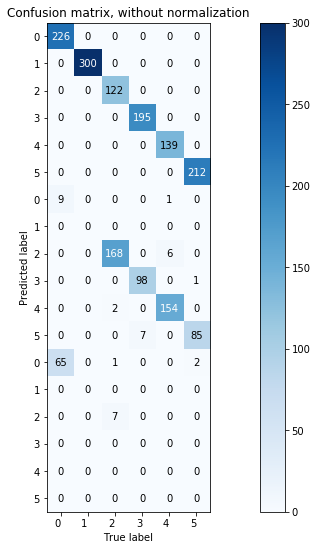

----------------------
46
Epsilon for each layer: [24.251465064166364, 3.0314331330207955]
M1:  0.6294444444444445
M2:  0.9999999999991174
M3:  0.9729729729714262
M4:  0.34944444444444445
M5:  0.021111111111111112
M6:  0.060413354530905544


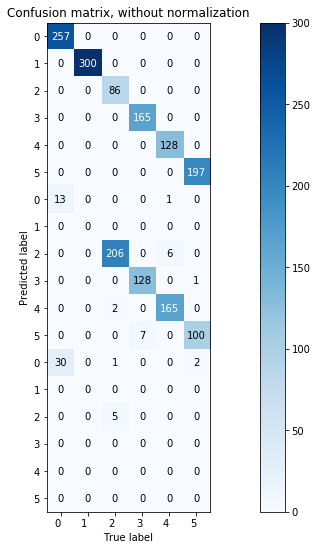

----------------------
47
Epsilon for each layer: [25.99207668339954, 3.2490095854249423]
M1:  0.575
M2:  0.9999999999990338
M3:  0.9773936170199768
M4:  0.4177777777777778
M5:  0.007222222222222222
M6:  0.017287234042530204


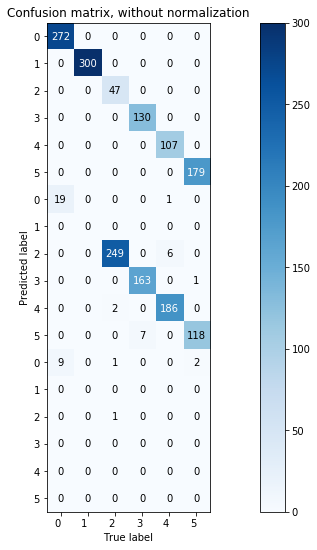

----------------------
48
Epsilon for each layer: [27.85761802547597, 3.482202253184496]
M1:  0.5138888888888888
M2:  0.999999999998919
M3:  0.9804147465426493
M4:  0.4822222222222222
M5:  0.0038888888888888888
M6:  0.008064516129022967


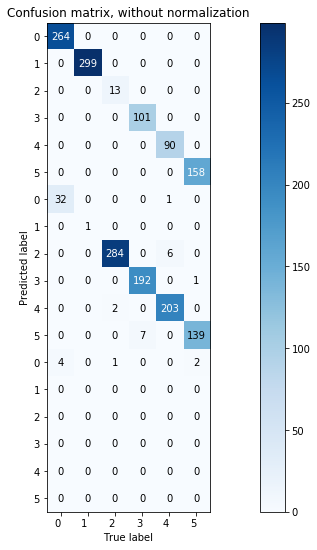

----------------------
49
Epsilon for each layer: [29.857055729177844, 3.7321319661472305]
M1:  0.44666666666666666
M2:  0.9999999999987562
M3:  0.9809045226120795
M4:  0.5527777777777778
M5:  0.0005555555555555556
M6:  0.0010050251256271305


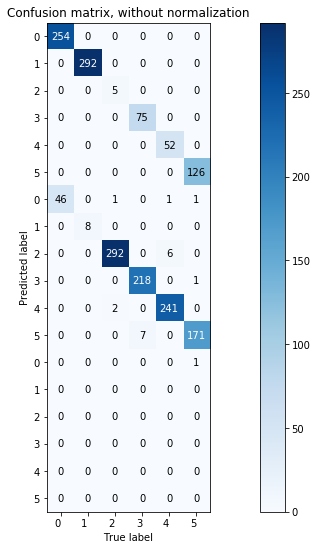

----------------------


In [18]:
for i in range(30, 50):
    print(i)
    print('Epsilon for each layer:', [2**(i/10), 2**(i/10-3)]) #randomly chosen value for epsilon to demo the concept
    pred = EC.predict_class(X_test, dist = [2**(i/10), 2**(i/10-3)]) # list represent epi in each layer
    plot_confusion_matrix(y_test_int, pred,  model.predict_classes(X_test))
    print('----------------------')

# Bayesian Opt for parameter tuning

fitness func:  0.030555555555555555
fitness func:  0.1527777777777778
fitness func:  0.6
fitness func:  0.1527777777777778
fitness func:  0.0
fitness func:  0.06111111111111111
fitness func:  0.05277777777777778
fitness func:  0.1527777777777778
fitness func:  0.6361111111111111
fitness func:  0.6527777777777778
fitness func:  0.6222222222222222
fitness func:  0.7
fitness func:  0.7333333333333333
fitness func:  0.49444444444444446
fitness func:  0.6555555555555556
fitness func:  0.1361111111111111
fitness func:  0.675
fitness func:  0.6472222222222223
fitness func:  0.011111111111111112
fitness func:  0.7361111111111112
fitness func:  0.6222222222222222
fitness func:  0.0
fitness func:  0.6444444444444445
fitness func:  0.4361111111111111
fitness func:  0.09722222222222222
fitness func:  0.011111111111111112
fitness func:  0.325
fitness func:  0.6777777777777778
fitness func:  0.5527777777777778
fitness func:  0.002777777777777778
fitness func:  0.7277777777777777
fitness func:  0.369

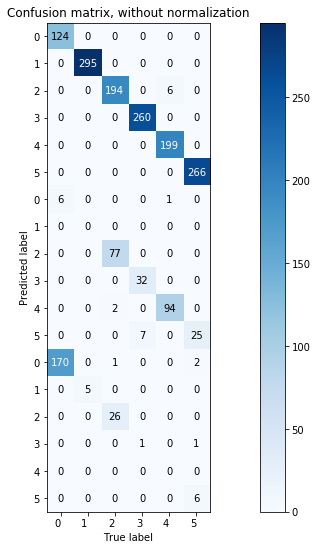

In [19]:
# Using BO to determine epsilon from validation data
max_iter = 50
def objF(x):
    epi_1 = x[:, 0]
    epi_2 = x[:, 1]
    pred = EC.predict_class(X_validation, dist = [epi_1, epi_2])
    raw_pred = model.predict_classes(X_validation)
    score = I_Know_Percent(y_validation_int, pred, raw_pred)
    print('fitness func: ', score)
    return -score

bounds = [{'name': 'x', 'type': 'continuous', 'domain': (4,35)},
          {'name': 'y', 'type': 'continuous', 'domain': (0.1,8)}]

myProblem = GPyOpt.methods.BayesianOptimization(objF,bounds)
myProblem.run_optimization(max_iter)
print(myProblem.x_opt)
pred = EC.predict_class(X_test, dist = list(myProblem.x_opt)) # list represent epi in each layer
plot_confusion_matrix(y_test_int, pred,  model.predict_classes(X_test))